QUESTION 1

In [1]:
%matplotlib inline
from time import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from scipy.stats import randint



Before we can dive into the fun stuff, we must first load in the dataset
The data is stored in a folder called "data" as a comma-separated text file.

In [2]:
df = pd.read_csv('./data.csv')

Data has been loaded from the CSV file and now available for processing.

Now that we have the data in memory, let's take a look at the size of the
data, namely the number of rows and columns.

In [3]:
df.shape

(689, 16)

There are 689 rows - For the purpose of this assignment, we shall interpert this
as 689 credit card applications submissions

There are 16 columns - For the purpose of this assignment, we shall interpert this
as possible different bio, demograophic and other criteria specific to the credit card application asked for each of the users applying. 

Let's get a sense of the dimensions/features being tracked by looking into the data types

In [4]:
df.dtypes

b         object
30.83     object
0        float64
u         object
g         object
w         object
v         object
1.25     float64
t         object
t.1       object
01         int64
f         object
g.1       object
00202     object
0.1        int64
+         object
dtype: object

We see two (2) data type of int64 (i.e. an integer), two (2) of float64 (i.e. decimals) and the remaining twelve (12) are of type object.

For the reamining fields, the data type of object is not immediately helpful as this can represent textual types of content. There is even the possibility that data could be missing/corrupt/invalid as well.

Let's now get a sense of the quality of data (e.g. consistency, valid content values/ranges, etc.)

We begin this process by taking a peek of the data set for some inspections to get a sense.

In [5]:
df.head()

,b,30.83,0,u,g,w,v,1.25,t,t.1,01,f,g.1,00202,0.1,+
0,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
1,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
2,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
3,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
4,b,32.08,4.000,u,g,m,v,2.50,t,f,0,t,g,00360,0,+


From the peek above, we see that most of the object data type fields seems to have a fixed set of values and as such are good candidates for categorical values.

Let's find out if there any columns with all rows with missing data. Then let's find out which columns have at least 1 row with missing data (via the use of NaN).

In [6]:
all_nan_cols = df.columns[df.isnull().all()]
all_nan_cols

Index([], dtype='object')

In [7]:
any_nan_cols = df.columns[df.isnull().any()]
any_nan_cols

Index([], dtype='object')

Let's take a peak at each of the columns and get a sense of the range of values each contain and look for any anomolies

In [8]:
for col in df.columns:
    print(df[col].describe())
    print(df[col].unique())
    print()

count     689
unique      3
top         b
freq      467
Name: b, dtype: object
['a' 'b' '?']

count     689
unique    349
top         ?
freq       12
Name: 30.83, dtype: object
['58.67' '24.50' '27.83' '20.17' '32.08' '33.17' '22.92' '54.42' '42.50'
 '22.08' '29.92' '38.25' '48.08' '45.83' '36.67' '28.25' '23.25' '21.83'
 '19.17' '25.00' '47.75' '27.42' '41.17' '15.83' '47.00' '56.58' '57.42'
 '42.08' '29.25' '42.00' '49.50' '36.75' '22.58' '27.25' '23.00' '27.75'
 '54.58' '34.17' '28.92' '29.67' '39.58' '56.42' '54.33' '41.00' '31.92'
 '41.50' '23.92' '25.75' '26.00' '37.42' '34.92' '34.25' '23.33' '23.17'
 '44.33' '35.17' '43.25' '56.75' '31.67' '23.42' '20.42' '26.67' '36.00'
 '25.50' '19.42' '32.33' '34.83' '38.58' '44.25' '44.83' '20.67' '34.08'
 '21.67' '21.50' '49.58' '27.67' '39.83' '?' '37.17' '25.67' '34.00'
 '49.00' '62.50' '31.42' '52.33' '28.75' '28.58' '22.50' '28.50' '37.50'
 '35.25' '18.67' '54.83' '40.92' '19.75' '29.17' '24.58' '33.75' '25.42'
 '37.75' '52.50' '57.83'

We see that there are a lot of columns which fixed range values (categorical) and there are continuous fields as well.

Furthermore, we see there are some columns which contain '?' character. We can consider this as missing data.

We also see the last column contains '+' (approved) and '-' (declined) values. This column will serve as our truth label column. We'll evnetually remove this column from the data set.

Let's determine which columns which contain '?' values

In [9]:
missing_value_cols = list(df.columns[df.isin(['?']).any()])
missing_value_cols

['b', '30.83', 'u', 'g', 'w', 'v', '00202']

Let's convert the '?' character in each of the columns above to NaN

In [10]:
df[missing_value_cols] = df[missing_value_cols].replace('?', np.NaN)

Next we are going to perform imputing and data type conversion for each of the columns above.

First off we create a new array which will be of the same length and each element will represent the desired data type the coloum should be treated as.

Based on inspection there's a pattern for infering data types
1. columns starting with a letter character a plus the last column are categorical
2. columns containing a decimal point are floats
3. columns remaining are ints

So any field beinging with a letter, we'll treat it as an 'object', any column names with '.' character will be treated as a float and the rest will be treated as integer

We shall also replace, the NaN values in each column with the most frequent used value for the given column. For example based on value_counts above, we see column named 'b' the most frequent value is 'b'. So for each NaN in column 'b' will be replaced with 'b' as the value. The process is repeat for each column.

In [11]:
types = ['object' if item[0].isalpha() else ('float' if '.' in item else 'int') for item in missing_value_cols]
for index, col in enumerate(missing_value_cols):
    most_freq = df[col].value_counts().idxmax()
    df[col] = df[col].fillna(most_freq).astype(types[index])
df.head()

,b,30.83,0,u,g,w,v,1.25,t,t.1,01,f,g.1,00202,0.1,+
0,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
1,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
2,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
3,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+
4,b,32.08,4.000,u,g,m,v,2.50,t,f,0,t,g,360,0,+


In [12]:
print(list(df.columns[df.isin(['?']).any()]))
print(df.columns[df.isnull().any()])

[]
Index([], dtype='object')


Let's see the updated data types now

In [13]:
df.dtypes

b         object
30.83    float64
0        float64
u         object
g         object
w         object
v         object
1.25     float64
t         object
t.1       object
01         int64
f         object
g.1       object
00202      int64
0.1        int64
+         object
dtype: object

In [14]:
categorical_cols = df.loc[:, df.dtypes == 'object'].columns
print(categorical_cols)

Index(['b', 'u', 'g', 'w', 'v', 't', 't.1', 'f', 'g.1', '+'], dtype='object')


We still have a few object types, which are candidates to become categorical columns

Let's take a closer look at them to see their value ranges, etc.

In [15]:
for col in categorical_cols:
    print(df[col].describe())
    print(df[col].unique())
    print(df[col].value_counts())
    print()

count     689
unique      2
top         b
freq      479
Name: b, dtype: object
['a' 'b']
b    479
a    210
Name: b, dtype: int64

count     689
unique      3
top         u
freq      524
Name: u, dtype: object
['u' 'y' 'l']
u    524
y    163
l      2
Name: u, dtype: int64

count     689
unique      3
top         g
freq      524
Name: g, dtype: object
['g' 'p' 'gg']
g     524
p     163
gg      2
Name: g, dtype: int64

count     689
unique     14
top         c
freq      146
Name: w, dtype: object
['q' 'w' 'm' 'r' 'cc' 'k' 'c' 'd' 'x' 'i' 'e' 'aa' 'ff' 'j']
c     146
q      78
w      63
i      59
aa     54
ff     53
k      51
cc     41
x      38
m      38
d      30
e      25
j      10
r       3
Name: w, dtype: int64

count     689
unique      9
top         v
freq      407
Name: v, dtype: object
['h' 'v' 'bb' 'ff' 'j' 'z' 'o' 'dd' 'n']
v     407
h     138
bb     59
ff     57
z       8
j       8
dd      6
n       4
o       2
Name: v, dtype: int64

count     689
unique      2
top         t
fr

Based on inspection we can make a correction for column 'g' by changing 'gg' into 'g' given the low frequency. Assumption: Incorrect data

In [16]:
df['g'] = df['g'].replace('gg', 'g')

Convert the object columns to category types

In [17]:
df_cpy = df.copy()
categorical_names = {}
for feature in categorical_cols:
    #df_cpy[c] = df_cpy[c].astype('category')
    #df_cpy[c] = df_cpy[c].cat.codes
    
    le = LabelEncoder()
    le.fit(df_cpy[feature])
    df_cpy[feature] = le.transform(df_cpy[feature])
    categorical_names[feature] = le.classes_
df_cpy.head()

,b,30.83,0,u,g,w,v,1.25,t,t.1,01,f,g.1,00202,0.1,+
0,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,43,560,0
1,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,280,824,0
2,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,100,3,0
3,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,120,0,0
4,1,32.08,4.000,1,0,9,7,2.50,1,0,0,1,0,360,0,0


In [18]:
labels = df_cpy.iloc[:,-1]
df_cpy = df_cpy[df.columns[:-1]]

In [19]:
df_cpy.head()

,b,30.83,0,u,g,w,v,1.25,t,t.1,01,f,g.1,00202,0.1
0,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,43,560
1,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,280,824
2,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,100,3
3,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,120,0
4,1,32.08,4.000,1,0,9,7,2.50,1,0,0,1,0,360,0


In [20]:
labels.shape

(689,)

Let's split the data into training (80%) and test (20%) with shuffle

In [69]:
train, test, labels_train, labels_test = train_test_split(df_cpy, labels, shuffle=True, test_size=0.20)
train.shape, test.shape, labels_train.shape, labels_test.shape

((551, 15), (138, 15), (551,), (138,))

Let's scale the data now

In [81]:
scaler = StandardScaler()
scaler.fit(train)
X_train = scaler.transform(train)

scaler = StandardScaler()
scaler.fit(test)
X_test = scaler.transform(test)

In [82]:
pca = PCA(0.95)
pca.fit(X_train)
print (pca.n_components_)
X_train = pca.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = pca.transform(X_test)
X_test = pd.DataFrame(X_test)

13


In [83]:
X_train.shape, X_test.shape

((551, 13), (138, 13))

QUESTION 2 - PART 1

In [84]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, labels_train)
labels_pred = random_forest.predict(X_test)
acc_rf = round(accuracy_score(labels_test,labels_pred) * 100, 2)
print("RandomForestClassifier Accuracy %.2f" % (acc_rf))
print()
print(classification_report(labels_test, labels_pred))

RandomForestClassifier Accuracy 84.78

             precision    recall  f1-score   support

          0       0.83      0.84      0.83        63
          1       0.86      0.85      0.86        75

avg / total       0.85      0.85      0.85       138



QUESTION 2 - PART 2

In [85]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
param_dist = {"n_estimators": [20, 100],
              "max_depth": [3, None],
              "max_features": randint(1, pca.n_components_),
              "min_samples_split": randint(9, 11),
              "min_samples_leaf": randint(9, 11),
              "bootstrap": [True],
              "criterion": ["gini", "entropy"]}


n_iter_search = 20
rscv = RandomizedSearchCV(random_forest, param_distributions=param_dist, n_iter=n_iter_search)
start = time()
rscv.fit(X_train, labels_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
print()
report(rscv.cv_results_)
print()
print("Best score is %.2f" % (rscv.best_score_))
acc_rscv = round(rscv.best_score_ * 100, 2) 

RandomizedSearchCV took 6.35 seconds for 20 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.848 (std: 0.027)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.846 (std: 0.023)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.846 (std: 0.010)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 100}


Best score is 0.85


**QUESTION 3 - PART 1:**  

Using the KNN Classifier provided by the sklearn library

1. Initialize the classifier with default value for n_neighbors
2. Train the classifier
3. Determine the recall score of the classifier

In [86]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, labels_train)
labels_pred = knn.predict(X_test)
acc_knn = round(accuracy_score(labels_test,labels_pred) * 100, 2) 
print("KNeighborsClassifier Accuracy %.2f" % (acc_knn))
print()
print(classification_report(labels_test, labels_pred))

KNeighborsClassifier Accuracy 86.96

             precision    recall  f1-score   support

          0       0.91      0.79      0.85        63
          1       0.84      0.93      0.89        75

avg / total       0.87      0.87      0.87       138



**QUESTION 3 - PART 2:** 

1. Perform 10 fold cross validation to obtain the optimal value to use for n_neighbor
2. Retrain the classifier 
2. Determine the recall score of the classifier 


The optimal number of neighbors is 6 with 85.48%


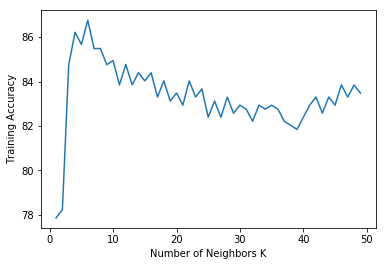

KNeighborsClassifier Accuracy 87.68

             precision    recall  f1-score   support

          0       0.86      0.87      0.87        63
          1       0.89      0.88      0.89        75

avg / total       0.88      0.88      0.88       138



In [87]:
# creating odd list of K for KNN
neighbors = list(filter(lambda x: True, list(range(1,50))))
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
seed = time()
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=2, metric='euclidean')
    kfold = KFold(n_splits=10, random_state=seed)
    scores = cross_val_score(knn, X_train, labels_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean() * 100)

# determining best k
optimized_k = neighbors[cv_scores.index(max(cv_scores))]
print("The optimal number of neighbors is %d with %0.2f%%" 
      % (optimized_k, cv_scores[optimized_k]))
# plot misclassification error vs k
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Training Accuracy')
plt.show()


knn = KNeighborsClassifier(n_neighbors=optimized_k)
knn.fit(X_train, labels_train)

# predict the response
labels_pred = knn.predict(X_test)

# evaluate accuracy
acc_knncv = round(accuracy_score(labels_test,labels_pred) * 100, 2)
print("KNeighborsClassifier Accuracy %.2f" % (acc_knncv))
print()
print(classification_report(labels_test, labels_pred))

In [88]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'Randomized Search CV','KNN', 'KNN CV'],
    'Score': [acc_rf, acc_rscv, acc_knn, acc_knncv ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,KNN CV,87.68
2,KNN,86.96
0,Random Forest,84.78
1,Randomized Search CV,84.75


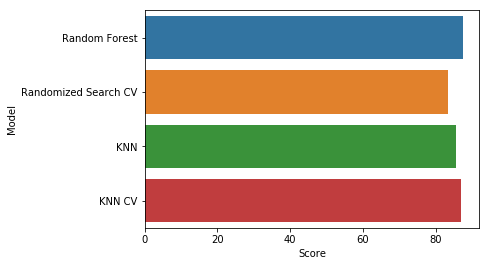

In [62]:
sns.barplot(x='Score', y='Model', data=models)